Iñigo Martin Melero

## Participante 19

Hacemos a lo que se refieren algunos papers. Nuestros datos de entrada son:

- Fisiológico: 2500000 elementos, medido milisegundo a milisegundo. 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10...
- Joystick: 40000 elementos, medido de 50 milisegundos en 50 milisegundos. 0, 50, 100, 150...

Cambiaremos los dataset de entrada para partir en igualdad de condiciones a los papers.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy import signal
from scipy import pi
from scipy.fftpack import rfft, rfftfreq

Leemos el csv del Joystick, y lo representamos.

In [2]:
df1=pd.read_csv('Bruto/sub_19_annotations.csv')
df1=df1.rename(columns={"jstime": "time"})
print(df1)

          time  valence  arousal  video
0            0      5.0      5.0     10
1           50      5.0      5.0     10
2          100      5.0      5.0     10
3          150      5.0      5.0     10
4          200      5.0      5.0     10
...        ...      ...      ...    ...
49027  2451350      5.0      5.0     12
49028  2451400      5.0      5.0     12
49029  2451450      5.0      5.0     12
49030  2451500      5.0      5.0     12
49031  2451550      5.0      5.0     12

[49032 rows x 4 columns]


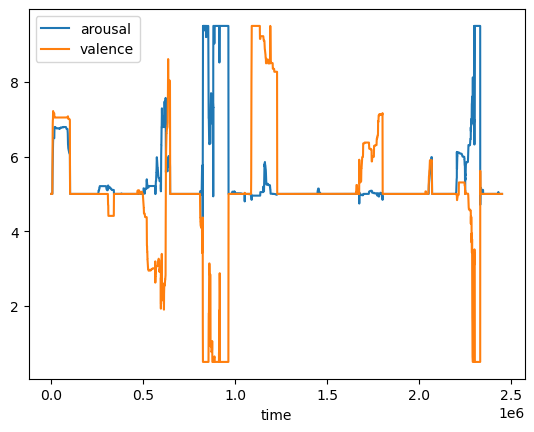

In [3]:
df1.plot(x="time", y=["arousal","valence"])
plt.show()

Leemos el csv de las variables Fisiológicas, y las representamos.

In [4]:
df2=pd.read_csv('Bruto/sub_19_physiological.csv')
df2=df2.rename(columns={"daqtime": "time"})
length_orig_df2=len(df2)
print(df2)

            time    ecg     bvp     gsr     rsp     skt  emg_zygo  emg_coru  \
0              0  0.761  37.237  31.035  29.875  23.556     6.014     7.494   
1              1  0.767  36.840  31.114  29.875  23.545     6.056     7.453   
2              2  0.774  36.443  31.193  29.875  23.535     6.097     7.412   
3              3  0.787  36.563  31.104  29.865  23.545     6.097     7.411   
4              4  0.797  36.680  31.150  29.875  23.545     6.097     7.371   
...          ...    ...     ...     ...     ...     ...       ...       ...   
2451579  2451579  0.830  36.643  29.988  29.991  23.265     5.192     6.178   
2451580  2451580  0.846  36.748  29.964  29.972  23.251     5.112     6.098   
2451581  2451581  0.840  36.844  29.968  29.972  23.254     5.152     6.097   
2451582  2451582  0.849  36.941  30.038  29.953  23.268     5.193     6.097   
2451583  2451583  0.853  36.530  30.027  29.953  23.261     5.153     6.097   

         emg_trap  video  
0           7.617     10

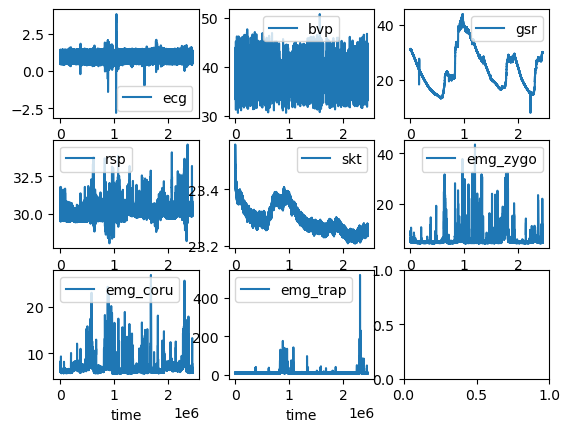

In [5]:
#define subplot layout
fig, axes = plt.subplots(nrows=3, ncols=3)

#add DataFrames to subplots
df2.plot(ax=axes[0,0],x="time",y="ecg")
df2.plot(ax=axes[0,1],x="time",y="bvp")
df2.plot(ax=axes[0,2],x="time",y="gsr")
df2.plot(ax=axes[1,0],x="time",y="rsp")
df2.plot(ax=axes[1,1],x="time",y="skt")
df2.plot(ax=axes[1,2],x="time",y="emg_zygo")
df2.plot(ax=axes[2,0],x="time",y="emg_coru")
df2.plot(ax=axes[2,1],x="time",y="emg_trap")
plt.show()

<AxesSubplot:xlabel='time'>

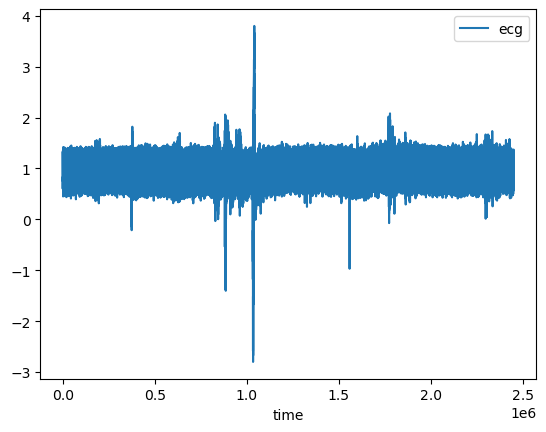

In [6]:
df2.plot(x="time",y="ecg")

<AxesSubplot:xlabel='time'>

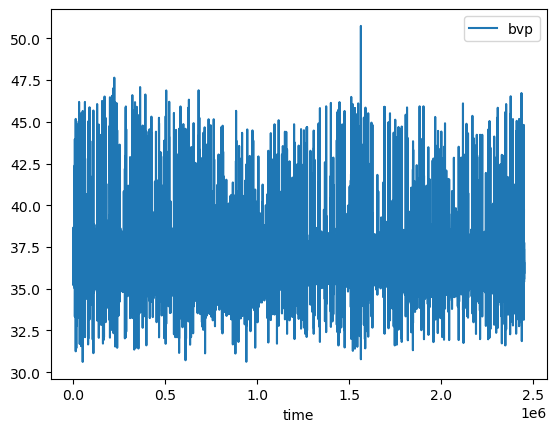

In [7]:
df2.plot(x="time",y="bvp")

<AxesSubplot:xlabel='time'>

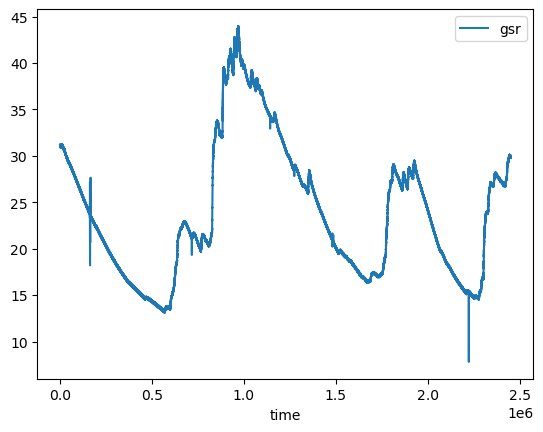

In [8]:
df2.plot(x="time",y="gsr")

<AxesSubplot:xlabel='time'>

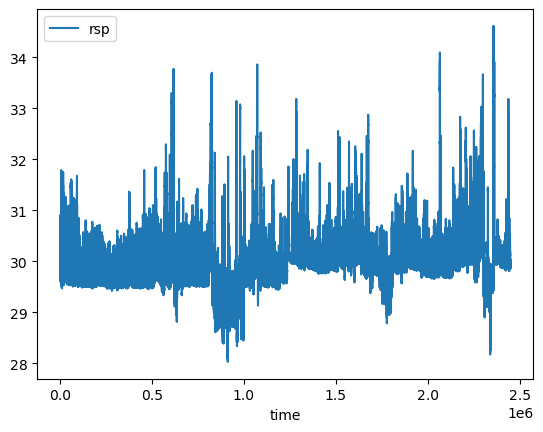

In [9]:
df2.plot(x="time",y="rsp")

<AxesSubplot:xlabel='time'>

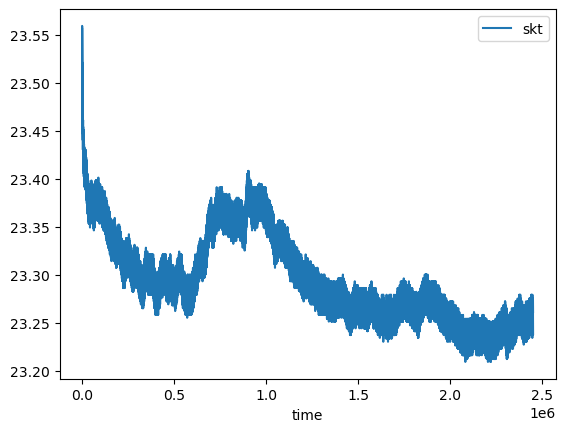

In [10]:
df2.plot(x="time",y="skt")


<AxesSubplot:xlabel='time'>

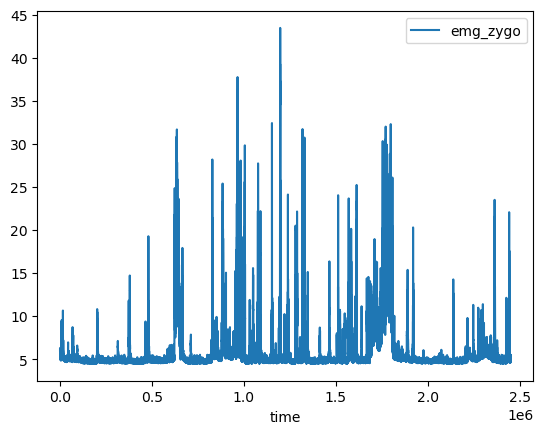

In [11]:
df2.plot(x="time",y="emg_zygo")


<AxesSubplot:xlabel='time'>

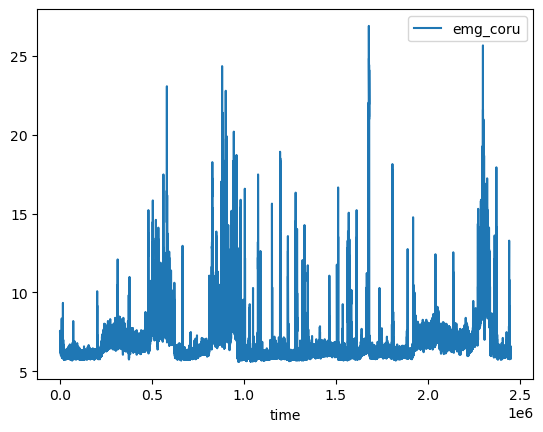

In [12]:
df2.plot(x="time",y="emg_coru")

<AxesSubplot:xlabel='time'>

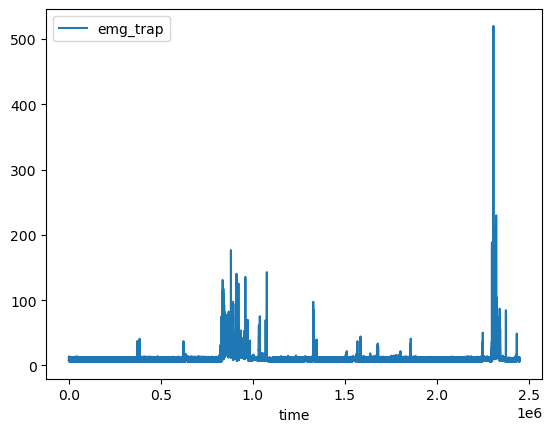

In [13]:
df2.plot(x="time",y="emg_trap")

El paper más completo que trata esto es CorrNet, donde se hace:

"Since the sampling rates of V-A and signals are 20 and 1000 Hz
respectively, we down-sampled all the signals to 50 Hz by decimation down-sampling. The EDA signals were
first filtered using a low pass filter with a 2 Hz cutoff frequency to remove noise.
For the BVP signal, we pre-processed it with a four-order butterworth bandpass filter with
cutoff frequencies [30, 200] Hz to eliminate the bursts. An elliptic band-pass filter
with cutoff frequencies [0.005, 0.1] was used to filter the ST signal. We followed the
standard filtering procedure widely used in previous works to pre-process the
physiological signals. Then the filtered signals are segmented into 2-second (sample size:
100 for CASE) instances."

O sea:

A) Se pasa filtro paso bajo 2 Hz a señales EDA (GSR).

B) Se pasa filtro de cuarto orden butterworth con frecuencias corte [30, 200] Hz a señal BVP.

C) Se utiliza un filtro de paso eliptico con frecuencias corte [0.005, 0.1] a señal ST (SKT).

D) Se normalizan las señales a 0 - 1, segun Min - Max.

E) Se busca la frecuencia en común de ambos a 50 Hz. Se hizo un estudio y fue la solución de compromiso.

F) Se utilizan ventanas de 2 segundos.

Lo vamos haciendo poco a poco.

    A) Se pasa filtro paso bajo 2 Hz a señales EDA (GSR).

<AxesSubplot:>

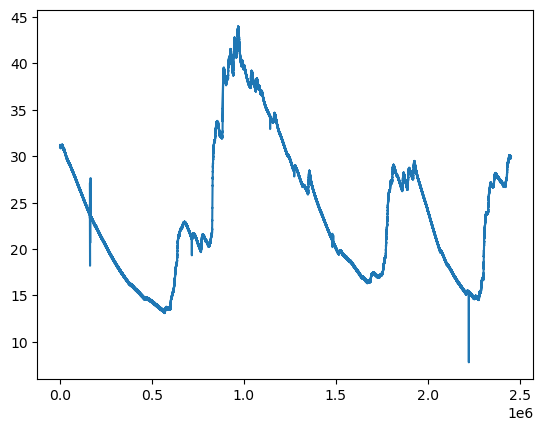

In [14]:
gsr_signal_notfiltered=df2['gsr']
gsr_signal_notfiltered.plot()

Representamos la senal en el dominio de la frecuencia. Vemos que hay frecuencias hasta el 500. Las querremos quitar todas menos las menores a 2 Hz. 

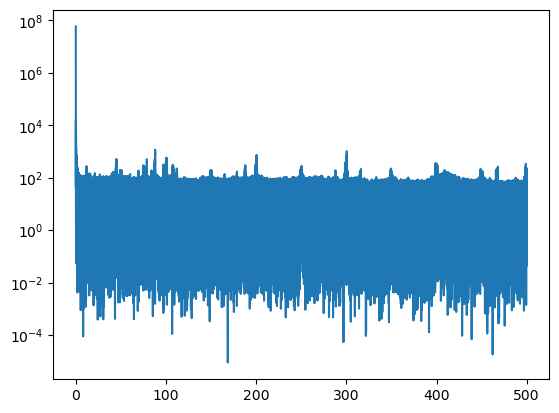

In [15]:
yf = rfft(gsr_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

In [16]:
lowpassfilter=signal.butter(N=10, Wn=2, btype='lp', fs=1000, output='sos')
gsr_filtered = signal.sosfilt(lowpassfilter, gsr_signal_notfiltered)

Comprobamos la senal filtrada. No deberia tener (o tener amplitud muy reducida) en las frecuencias a partir de los 2 Hz. Efectivamente vemos que se ha hecho lo mejor que se ha podido, y se han reducido notablemente las frecuencias mayores a 2 Hz. 

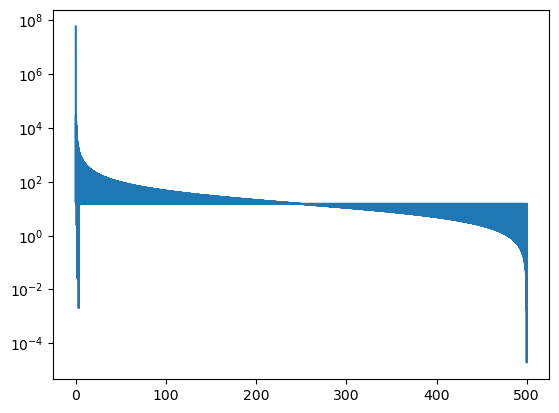

In [17]:
yf = rfft(gsr_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

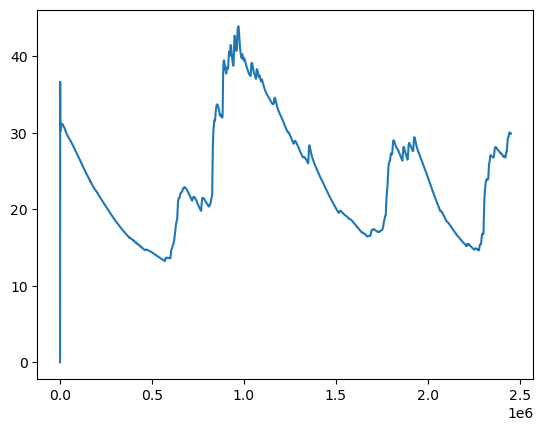

In [18]:
plt.plot(gsr_filtered)

In [19]:
gsr_signal_filtered = pd.DataFrame(gsr_filtered)
gsr_signal_filtered=gsr_signal_filtered.round(3)
gsr_signal_filtered=gsr_signal_filtered.rename(columns={0: "gsr"})
gsr_signal_filtered

gsr
0         0.000
1         0.000
2         0.000
3         0.000
4         0.000
...         ...
2451579  29.905
2451580  29.905
2451581  29.905
2451582  29.905
2451583  29.905

[2451584 rows x 1 columns]

B) Se pasa filtro de cuarto orden butterworth con frecuencias corte [30, 200] Hz a señal BVP.

<AxesSubplot:>

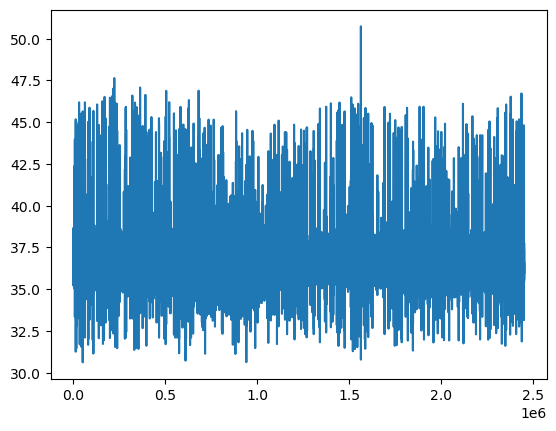

In [20]:
bvp_signal_notfiltered=df2['bvp']
bvp_signal_notfiltered.plot()

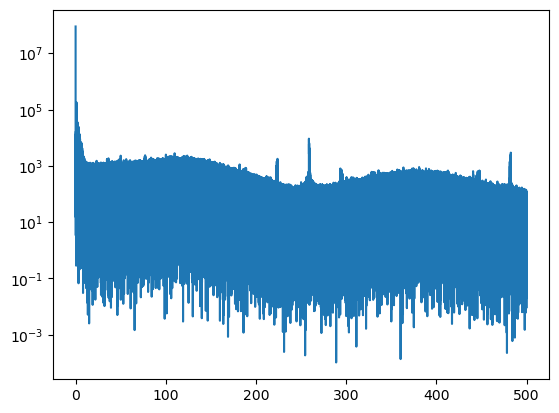

In [21]:
yf = rfft(bvp_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

Configuramos el filtro Butter con frecuencias de corte de 30 a 200 Hz, de cuarto orden. Es un filtro paso banda.

In [22]:
butterfilter=signal.butter(N=4, Wn=[30,200], btype='bandpass', fs=1000, output='sos')
bvp_filtered = signal.sosfilt(butterfilter, bvp_signal_notfiltered)

Comprobamos la senal filtrada. No deberia tener (o tener amplitud muy reducida) en las frecuencias menores de 30 Hz y mayores a 200 Hz. Efectivamente vemos que se ha hecho lo mejor que se ha podido, y se han reducido notablemente esas frecuencias.

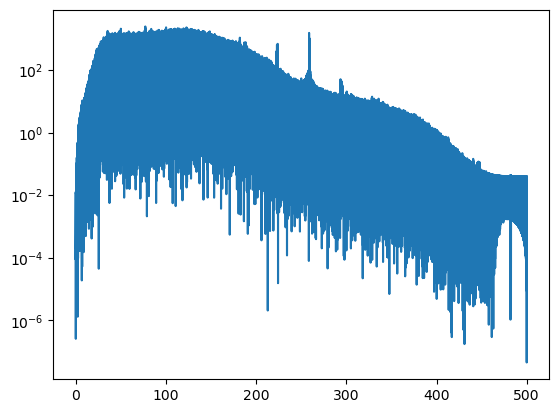

In [23]:
yf = rfft(bvp_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

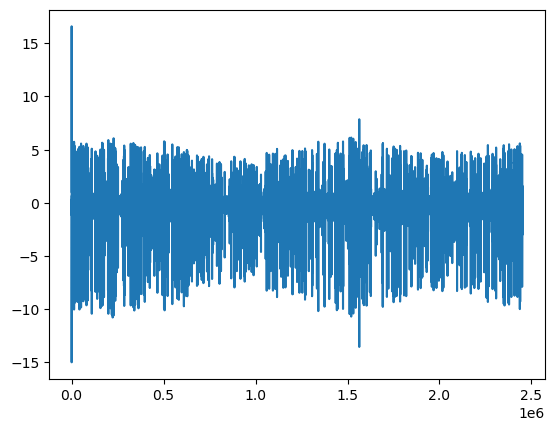

In [24]:
plt.plot(bvp_filtered)

Vemos que el paso banda está centrado en el 0, por lo que lo offseteamos a arriba. Este problema le pasa a más gente, así que no pasa nada. Luego, como normalizaremos los datos, este efecto se eliminará lo offseteemos lo que lo offseteemos.

In [25]:
bvp_signal_filtered = pd.DataFrame(bvp_filtered)
bvp_signal_filtered=bvp_signal_filtered.round(3)
bvp_signal_filtered=bvp_signal_filtered.rename(columns={0: "bvp"})
bvp_signal_filtered=bvp_signal_filtered.add(37)
bvp_signal_filtered

bvp
0        38.035
1        42.761
2        50.508
3        53.589
4        46.091
...         ...
2451579  36.922
2451580  36.952
2451581  37.012
2451582  37.057
2451583  37.077

[2451584 rows x 1 columns]

    C) Se utiliza un filtro de paso eliptico con frecuencias corte [0.005, 0.1] a señal ST (SKT).

<AxesSubplot:>

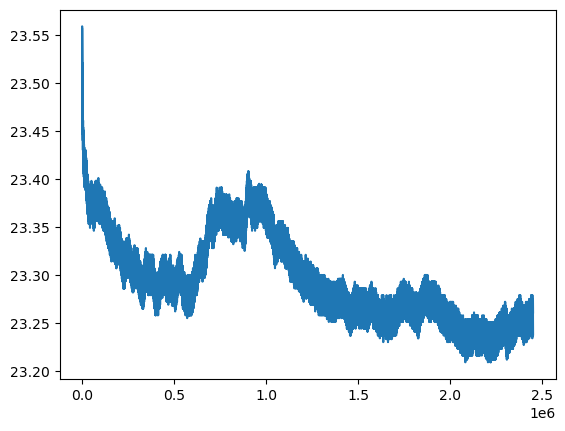

In [26]:
skt_signal_notfiltered=df2['skt']
skt_signal_notfiltered.plot()

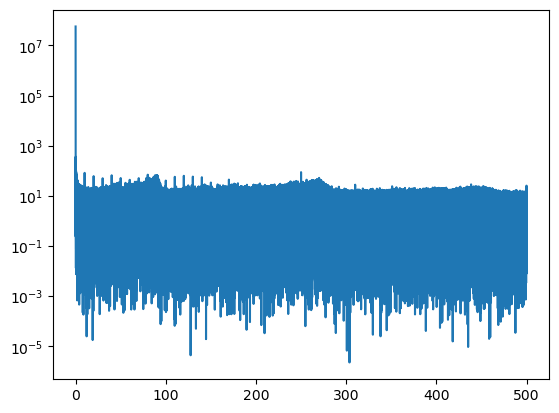

In [27]:
yf = rfft(skt_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

Configuramos nuestro filtro eliptico con frecuencias corte [0.005, 0.1] a señal skt.

In [28]:
ellipticfilter=signal.ellip(N=4,rp=1, rs=1, Wn=[0.005,0.1], btype='bandpass', fs=1000, output='sos')
skt_filtered = signal.sosfilt(ellipticfilter, skt_signal_notfiltered)

Comprobamos la senal filtrada. Algo ha filtrado.

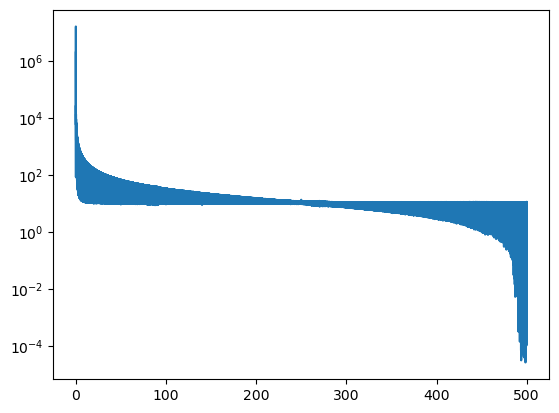

In [29]:
yf = rfft(skt_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

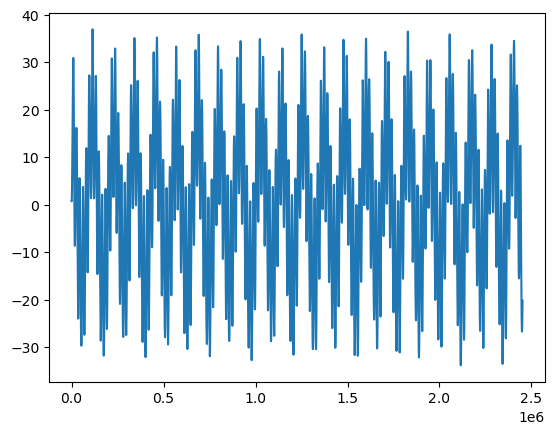

In [30]:
plt.plot(skt_filtered)

Vemos que el paso banda está centrado en el 0, por lo que lo offseteamos a arriba. Este problema le pasa a más gente, así que no pasa nada. Luego, como normalizaremos los datos, este efecto se eliminará lo offseteemos lo que lo offseteemos.

In [31]:
skt_signal_filtered = pd.DataFrame(skt_filtered)
skt_signal_filtered=skt_signal_filtered.round(3)
skt_signal_filtered=skt_signal_filtered.rename(columns={0: "skt"})
skt_signal_filtered=skt_signal_filtered.add(40)
skt_signal_filtered

skt
0        40.755
1        40.755
2        40.754
3        40.755
4        40.755
...         ...
2451579  19.835
2451580  19.839
2451581  19.843
2451582  19.847
2451583  19.851

[2451584 rows x 1 columns]

D) Se normalizan las senales.

Antes de normalizarlas, vamos a borrar las primeras 5000, ya que por los filtrados los principios de las senales son un poco raros. Borramos las columnas que acabamos de tunear del dataframe con todo.

In [32]:
df2=df2.drop(columns=["skt","bvp","gsr"])
df2

time    ecg     rsp  emg_zygo  emg_coru  emg_trap  video
0              0  0.761  29.875     6.014     7.494     7.617     10
1              1  0.767  29.875     6.056     7.453     7.535     10
2              2  0.774  29.875     6.097     7.412     7.453     10
3              3  0.787  29.865     6.097     7.411     7.412     10
4              4  0.797  29.875     6.097     7.371     7.452     10
...          ...    ...     ...       ...       ...       ...    ...
2451579  2451579  0.830  29.991     5.192     6.178     6.752     12
2451580  2451580  0.846  29.972     5.112     6.098     6.632     12
2451581  2451581  0.840  29.972     5.152     6.097     6.631     12
2451582  2451582  0.849  29.953     5.193     6.097     6.672     12
2451583  2451583  0.853  29.953     5.153     6.097     6.631     12

[2451584 rows x 7 columns]

In [33]:
df2=pd.concat([df2, bvp_signal_filtered, gsr_signal_filtered,skt_signal_filtered], axis=1)
df2

time    ecg     rsp  emg_zygo  emg_coru  emg_trap  video     bvp  \
0              0  0.761  29.875     6.014     7.494     7.617     10  38.035   
1              1  0.767  29.875     6.056     7.453     7.535     10  42.761   
2              2  0.774  29.875     6.097     7.412     7.453     10  50.508   
3              3  0.787  29.865     6.097     7.411     7.412     10  53.589   
4              4  0.797  29.875     6.097     7.371     7.452     10  46.091   
...          ...    ...     ...       ...       ...       ...    ...     ...   
2451579  2451579  0.830  29.991     5.192     6.178     6.752     12  36.922   
2451580  2451580  0.846  29.972     5.112     6.098     6.632     12  36.952   
2451581  2451581  0.840  29.972     5.152     6.097     6.631     12  37.012   
2451582  2451582  0.849  29.953     5.193     6.097     6.672     12  37.057   
2451583  2451583  0.853  29.953     5.153     6.097     6.631     12  37.077   

            gsr     skt  
0         0.000  40.755  
1         0.000  40.755  
2         0.000  40.754  
3         0.000  40.755  
4         0.000  40.755  
...         ...     ...  
2451579  29.905  19.835  
2451580  29.905  19.839  
2451581  29.905  19.843  
2451582  29.905  19.847  
2451583  29.905  19.851  

[2451584 rows x 10 columns]

Tras aclarar esto, ya pasamos a normalizar. Antes, quitamos los videos que van al train, para que se normalicen solo los datos que van a ser entrenados realmente (sin los videos de BlueScreen, EndVid y StartVid).

In [34]:
df2 = df2[df2.video != 10]
df2 = df2[df2.video != 11]
df2 = df2[df2.video != 12]
scaler = MinMaxScaler()
scaler.fit(df2)
normalized = pd.DataFrame(scaler.transform(df2), index=df2.index, columns=df2.columns)
df2_normalized = pd.DataFrame(normalized, columns=df2.columns)
df2_normalized=df2_normalized.drop(columns=["video","time"])
numvideo_bien = df2["video"] 
tiempo_bien=df2["time"] 
df2_normalized=df2_normalized.join(numvideo_bien)
df2_normalized=df2_normalized.join(tiempo_bien)
df2=df2_normalized[["time","ecg","bvp","gsr","skt","rsp","emg_zygo","emg_coru","emg_trap","video"]]
df2

time       ecg       bvp       gsr       skt       rsp  emg_zygo  \
221501    221501  0.630703  0.643904  0.277684  0.781586  0.252101  0.007331   
221502    221502  0.627834  0.642895  0.277684  0.781512  0.253584  0.011484   
221503    221503  0.627834  0.641887  0.277684  0.781438  0.255232  0.009433   
221504    221504  0.633286  0.640403  0.277684  0.781349  0.255232  0.010458   
221505    221505  0.630703  0.636903  0.277684  0.781275  0.253584  0.009407   
...          ...       ...       ...       ...       ...       ...       ...   
2331579  2331579  0.603156  0.644972  0.419324  0.347782  0.301532  0.022044   
2331580  2331580  0.590244  0.644379  0.419324  0.347871  0.296754  0.023095   
2331581  2331581  0.588235  0.643667  0.419324  0.347960  0.303015  0.026223   
2331582  2331582  0.588235  0.641531  0.419358  0.348034  0.309441  0.025197   
2331583  2331583  0.582496  0.640819  0.419358  0.348123  0.298402  0.023121   

         emg_coru  emg_trap  video  
221501   0.025202  0.001113      3  
221502   0.032847  0.001033      3  
221503   0.034829  0.001191      3  
221504   0.032942  0.001113      3  
221505   0.031007  0.001113      3  
...           ...       ...    ...  
2331579  0.335221  0.049567      8  
2331580  0.339138  0.057119      8  
2331581  0.346831  0.065408      8  
2331582  0.344990  0.072282      8  
2331583  0.343055  0.077484      8  

[1270083 rows x 10 columns]

    E) Frecuencia común 50 Hz

Para la frecuencia comun a ambos, ello implica tener lecturas cada 1/50 = 20 ms. Para las senales fisiologicas lo tenemos, pero para las annotations no, por lo que hay que resample. Primero resampleamos a que nos saque todos los valores por milisegundo de annotations, y luego downsampleamos para quedarnos solo con los que sean menores a 20 ms. 

In [35]:
n_samples=length_orig_df2
df1_clean=df1.drop(columns=['time', 'video'])
array1_resampled=signal.resample(df1_clean, n_samples)
df1_resampled=pd.DataFrame(array1_resampled,columns=["valence","arousal"])
df1_resampled=df1_resampled.round(3)
print(df1_resampled)

         valence  arousal
0            5.0      5.0
1            5.0      5.0
2            5.0      5.0
3            5.0      5.0
4            5.0      5.0
...          ...      ...
2451579      5.0      5.0
2451580      5.0      5.0
2451581      5.0      5.0
2451582      5.0      5.0
2451583      5.0      5.0

[2451584 rows x 2 columns]


Unimos los csv, con columna intersección en "time". Borramos los instantes de tiempo X e Y porque en realidad no son necesarios. Reordenamos las columnas.

In [36]:
df3=pd.merge(df1_resampled, df2, left_index=True, right_index=True)

columnsTitles = ['time', 'ecg', 'bvp','gsr','rsp','skt','emg_zygo','emg_coru','emg_trap','valence','arousal','video']
df3 = df3.reindex(columns=columnsTitles)

print(df3)

            time       ecg       bvp       gsr       rsp       skt  emg_zygo  \
221501    221501  0.630703  0.643904  0.277684  0.252101  0.781586  0.007331   
221502    221502  0.627834  0.642895  0.277684  0.253584  0.781512  0.011484   
221503    221503  0.627834  0.641887  0.277684  0.255232  0.781438  0.009433   
221504    221504  0.633286  0.640403  0.277684  0.255232  0.781349  0.010458   
221505    221505  0.630703  0.636903  0.277684  0.253584  0.781275  0.009407   
...          ...       ...       ...       ...       ...       ...       ...   
2331579  2331579  0.603156  0.644972  0.419324  0.301532  0.347782  0.022044   
2331580  2331580  0.590244  0.644379  0.419324  0.296754  0.347871  0.023095   
2331581  2331581  0.588235  0.643667  0.419324  0.303015  0.347960  0.026223   
2331582  2331582  0.588235  0.641531  0.419358  0.309441  0.348034  0.025197   
2331583  2331583  0.582496  0.640819  0.419358  0.298402  0.348123  0.023121   

         emg_coru  emg_trap  valence  a

Downsampleamos a 20 ms y eliminamos la columna tiempo. 

In [37]:
df3 = df3.drop(df3[df3.time%20 != 0].index)
df3 = df3.drop(columns=['time'])
print(df3)

              ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
221520   0.627547  0.634886  0.277684  0.258362  0.780133  0.010433  0.031007   
221540   0.627547  0.633521  0.277684  0.255232  0.778591  0.009407  0.025155   
221560   0.622095  0.635835  0.277684  0.256879  0.777065  0.013586  0.028977   
221580   0.624964  0.640581  0.277684  0.253749  0.775523  0.008356  0.025155   
221600   0.633286  0.643429  0.277684  0.255232  0.773981  0.009407  0.027090   
...           ...       ...       ...       ...       ...       ...       ...   
2331500  0.633286  0.644972  0.418510  0.298237  0.341229  0.026248  0.236491   
2331520  0.603156  0.640937  0.418714  0.295106  0.342890  0.023121  0.277125   
2331540  0.600287  0.714981  0.418917  0.303015  0.344550  0.028325  0.236491   
2331560  0.592826  0.637318  0.419121  0.303015  0.346210  0.025223  0.213177   
2331580  0.590244  0.644379  0.419324  0.296754  0.347871  0.023095  0.339138   

         emg_trap  valence 

Creamos la ventana de n = 2 segundos. Una ventana de datos simplemente será concatenar los datos dentro de grupos de 2 segundos, haciendo la media de valencia y de arousal de todos ellos. 

Como la frecuencia de muestreo son 20 ms, cada ventana de 2 segundos tendrá en total 100 observaciones. Después, esto lo "flattenaremos" para que el modelo ML en R pueda tragarlo.  

En primer lugar, como las ventanas son de 2 segundos, eliminamos un número de datos para que nos den las ventanas justas. Tendríamos varios criterios:

- A) Ver en el completo de los datos las entradas que tenemos múltiplos de 100 (ventanas de 2 s), y eliminar del múltiplo más alto hasta el final.

- B) Algo más fino quizá sería hacer lo mismo pero video a video. 

Por simplicidad y ver lo que sale hacemos A). Comenzamos creando un nuevo indice desde 0 del Dataframe que tenemos y borramos el valor del video. 

In [38]:
df3 = df3.drop(columns=['video'])
df3 = df3.reset_index()
df3 = df3.drop(columns=['index'])
df3

ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
0      0.627547  0.634886  0.277684  0.258362  0.780133  0.010433  0.031007   
1      0.627547  0.633521  0.277684  0.255232  0.778591  0.009407  0.025155   
2      0.622095  0.635835  0.277684  0.256879  0.777065  0.013586  0.028977   
3      0.624964  0.640581  0.277684  0.253749  0.775523  0.008356  0.025155   
4      0.633286  0.643429  0.277684  0.255232  0.773981  0.009407  0.027090   
...         ...       ...       ...       ...       ...       ...       ...   
63499  0.633286  0.644972  0.418510  0.298237  0.341229  0.026248  0.236491   
63500  0.603156  0.640937  0.418714  0.295106  0.342890  0.023121  0.277125   
63501  0.600287  0.714981  0.418917  0.303015  0.344550  0.028325  0.236491   
63502  0.592826  0.637318  0.419121  0.303015  0.346210  0.025223  0.213177   
63503  0.590244  0.644379  0.419324  0.296754  0.347871  0.023095  0.339138   

       emg_trap  valence  arousal  
0      0.001113      5.0      5.0  
1      0.001033      5.0      5.0  
2      0.001509      5.0      5.0  
3      0.001272      5.0      5.0  
4      0.001195      5.0      5.0  
...         ...      ...      ...  
63499  0.044572      0.5      9.5  
63500  0.039815      0.5      9.5  
63501  0.063197      0.5      9.5  
63502  0.044196      0.5      9.5  
63503  0.057119      0.5      9.5  

[63504 rows x 10 columns]

Como tenemos 63504 filas, necesitamos borrar solo las ultimas 4.

In [39]:
df3=df3.drop([63503, 63502, 63501, 63500])
df3

ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
0      0.627547  0.634886  0.277684  0.258362  0.780133  0.010433  0.031007   
1      0.627547  0.633521  0.277684  0.255232  0.778591  0.009407  0.025155   
2      0.622095  0.635835  0.277684  0.256879  0.777065  0.013586  0.028977   
3      0.624964  0.640581  0.277684  0.253749  0.775523  0.008356  0.025155   
4      0.633286  0.643429  0.277684  0.255232  0.773981  0.009407  0.027090   
...         ...       ...       ...       ...       ...       ...       ...   
63495  0.591105  0.642895  0.417662  0.303015  0.334574  0.031503  0.187975   
63496  0.604304  0.640819  0.417865  0.301532  0.336234  0.030478  0.174383   
63497  0.593687  0.638624  0.418069  0.301368  0.337909  0.031477  0.257492   
63498  0.591966  0.642361  0.418306  0.299885  0.339569  0.027325  0.263627   
63499  0.633286  0.644972  0.418510  0.298237  0.341229  0.026248  0.236491   

       emg_trap  valence  arousal  
0      0.001113      5.0      5.0  
1      0.001033      5.0      5.0  
2      0.001509      5.0      5.0  
3      0.001272      5.0      5.0  
4      0.001195      5.0      5.0  
...         ...      ...      ...  
63495  0.042445      0.5      9.5  
63496  0.092389      0.5      9.5  
63497  0.058554      0.5      9.5  
63498  0.047059      0.5      9.5  
63499  0.044572      0.5      9.5  

[63500 rows x 10 columns]

Y ahora si, con split dividimos el Dataset en 635 entradas de 100 datos cada una. 

In [40]:
df3_split_2s = np.array_split(df3, len(df3)/25)
df3_split_2s

[         ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
 0   0.627547  0.634886  0.277684  0.258362  0.780133  0.010433  0.031007   
 1   0.627547  0.633521  0.277684  0.255232  0.778591  0.009407  0.025155   
 2   0.622095  0.635835  0.277684  0.256879  0.777065  0.013586  0.028977   
 3   0.624964  0.640581  0.277684  0.253749  0.775523  0.008356  0.025155   
 4   0.633286  0.643429  0.277684  0.255232  0.773981  0.009407  0.027090   
 5   0.649354  0.639573  0.277684  0.253749  0.772440  0.005255  0.025202   
 6   0.659684  0.640819  0.277684  0.256879  0.770898  0.011509  0.032942   
 7   0.633286  0.637971  0.277650  0.255232  0.769341  0.008356  0.029072   
 8   0.614347  0.638090  0.277650  0.260010  0.767800  0.009433  0.029072   
 9   0.606887  0.633284  0.277616  0.256879  0.766243  0.007305  0.029024   
 10  0.606887  0.643192  0.277582  0.256879  0.764687  0.006254  0.030959   
 11  0.610617  0.637852  0.277582  0.260010  0.763130  0.008356  0.030912   

Ahora, realizaremos el Flatteneado. Las matrices las haremos una linea continua: pasamos de tener 100 observaciones de 8 variables a tener 1 observacion de 800 variables. 
Creamos el Dataframe que nos contenga todo, que tendrá 800 variables + Valence + Arousal (802 en total). Le ponemos nombre a las columnas del Dataframe solamente porque no se puede crear un Dataframe sin columnas, sino solo nos importaría llamar a la de Valence y Arousal.  

In [41]:
list_array = list(np.arange(1,201))
list_array.append("valence")
list_array.append("arousal")
df4 = pd.DataFrame(columns=list_array)
df4

Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, ...]
Index: []

[0 rows x 202 columns]

Y ahora hago el proceso de hacer el flatenning, y obtener el nuevo Dataframe con la ventana aplicada que exportaremos. Lo hacemos con un for para que repase todas las agrupaciones de 8 x 100 datos. De cada ventana calculamos (según papers) la valence y arousal promedios, y eso lo anadiremos en las ultimas dos columnas). 

In [42]:
for entrada in df3_split_2s:
    ave_valence=entrada['valence'].mean()
    ave_arousal=entrada['arousal'].mean()
    entrada=entrada.drop(columns=['valence','arousal'])
    a=entrada.to_numpy().flatten()
    a=np.append(a, ave_valence)
    a=np.append(a, ave_arousal)
    df4.loc[len(df4)] = a

In [43]:
df4

1         2         3         4         5         6         7  \
0     0.627547  0.634886  0.277684  0.258362  0.780133  0.010433  0.031007   
1     0.705882  0.642717  0.277107  0.298237  0.741235  0.008356  0.028977   
2     0.614634  0.635894  0.276462  0.370077  0.702115  0.007305  0.029024   
3     0.681492  0.647464  0.275411  0.312572  0.664107  0.010458  0.027090   
4     0.592826  0.636072  0.274596  0.263141  0.628322  0.011484  0.029024   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.624964  0.655651  0.373863  0.312737  0.156184  0.027325  0.240408   
2536  0.628694  0.640819  0.383227  0.293623  0.186410  0.023121  0.220964   
2537  0.617217  0.639276  0.393744  0.295106  0.221423  0.023121  0.234556   
2538  0.599426  0.642658  0.403481  0.296754  0.260128  0.030452  0.261598   
2539  0.589096  0.636784  0.412132  0.303015  0.301131  0.025172  0.232526   

             8         9        10  ...       193       194       195  \
0     0.001113  0.627547  0.633521  ...  0.691822  0.637615  0.277141   
1     0.001828  0.726542  0.641827  ...  0.613486  0.638564  0.276496   
2     0.001672  0.629555  0.638861  ...  0.721090  0.641531  0.275411   
3     0.001113  0.648494  0.632216  ...  0.617504  0.642065  0.274630   
4     0.000956  0.595696  0.640285  ...  0.609756  0.644675  0.274325   
...        ...       ...       ...  ...       ...       ...       ...   
2535  0.039093  0.636155  0.635954  ...  0.609756  0.640641  0.382820   
2536  0.041560  0.606026  0.632987  ...  0.609756  0.631207  0.393337   
2537  0.057272  0.615495  0.646514  ...  0.606026  0.645802  0.403108   
2538  0.057249  0.594835  0.636369  ...  0.573027  0.646099  0.411827   
2539  0.042651  0.728551  0.644557  ...  0.633286  0.644972  0.418510   

           196       197       198       199       200  valence  arousal  
0     0.295106  0.742807  0.007331  0.025155  0.001593      5.0      5.0  
1     0.363651  0.703672  0.005204  0.029024  0.001672      5.0      5.0  
2     0.317515  0.665589  0.010458  0.030959  0.001352      5.0      5.0  
3     0.266436  0.629686  0.008356  0.027137  0.001193      5.0      5.0  
4     0.252101  0.596896  0.007305  0.025155  0.001193      5.0      5.0  
...        ...       ...       ...       ...       ...      ...      ...  
2535  0.295106  0.185105  0.027299  0.259710  0.075167      0.5      9.5  
2536  0.299885  0.219956  0.028325  0.236396  0.047525      0.5      9.5  
2537  0.299885  0.258527  0.032605  0.220964  0.051474      0.5      9.5  
2538  0.304663  0.299471  0.025249  0.211289  0.061439      0.5      9.5  
2539  0.298237  0.341229  0.026248  0.236491  0.044572      0.5      9.5  

[2540 rows x 202 columns]

Para esta iteracion, analizamos los datos segun CorrNet. CorrNet propone 3 clasificaciones diferentes:
- Clasificación en 2 clases:
    
    Modelo ML A: Clasificamos Arousal en High y Low.
    
    Modelo ML B: Clasificamos Valence en High y Low. 


- Clasificación en 3 clases:
    
    Modelo ML C: Clasificamos Arousal en High, Neutral y Low.
   
    Modelo ML D: Clasificamos Valence en High, Neutral y Low.
    
    
- Clasificación en 4 clases:
    
    Modelo ML E: Clasificamos Valence y Arousal en los cuatro cuadrantes: High High, High Low, Low Low y Low High. 
   
   
Para cada uno, realizamos un dataframe diferente. 

- Modelo A. Clasificamos Arousal en High y Low. High --> 2 y Low --> 1

In [44]:
df4_A = df4.drop(columns=['valence'])
df4_A=df4_A.rename(columns={"arousal": "auxiliar"})
df4_A.loc[df4_A['auxiliar'] < 5, 'arousal'] = 1
df4_A.loc[df4_A['auxiliar'] >= 5, 'arousal'] = 2
df4_A = df4_A.drop(columns=['auxiliar'])
print(df4_A)

             1         2         3         4         5         6         7  \
0     0.627547  0.634886  0.277684  0.258362  0.780133  0.010433  0.031007   
1     0.705882  0.642717  0.277107  0.298237  0.741235  0.008356  0.028977   
2     0.614634  0.635894  0.276462  0.370077  0.702115  0.007305  0.029024   
3     0.681492  0.647464  0.275411  0.312572  0.664107  0.010458  0.027090   
4     0.592826  0.636072  0.274596  0.263141  0.628322  0.011484  0.029024   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.624964  0.655651  0.373863  0.312737  0.156184  0.027325  0.240408   
2536  0.628694  0.640819  0.383227  0.293623  0.186410  0.023121  0.220964   
2537  0.617217  0.639276  0.393744  0.295106  0.221423  0.023121  0.234556   
2538  0.599426  0.642658  0.403481  0.296754  0.260128  0.030452  0.261598   
2539  0.589096  0.636784  0.412132  0.303015  0.301131  0.025172  0.232526   

             8         9        10  ...       192       193    

In [45]:
df4_A.to_csv('Output/arousal_2_clases_sub19.csv', index=False)

- Modelo B. Clasificamos Valence en High y Low. High --> 2 y Low --> 1

In [46]:
df4_B = df4.drop(columns=['arousal'])
df4_B=df4_B.rename(columns={"valence": "auxiliar"})
df4_B.loc[df4_B['auxiliar'] < 5, 'valence'] = 1
df4_B.loc[df4_B['auxiliar'] >= 5, 'valence'] = 2
df4_B = df4_B.drop(columns=['auxiliar'])
print(df4_B)

             1         2         3         4         5         6         7  \
0     0.627547  0.634886  0.277684  0.258362  0.780133  0.010433  0.031007   
1     0.705882  0.642717  0.277107  0.298237  0.741235  0.008356  0.028977   
2     0.614634  0.635894  0.276462  0.370077  0.702115  0.007305  0.029024   
3     0.681492  0.647464  0.275411  0.312572  0.664107  0.010458  0.027090   
4     0.592826  0.636072  0.274596  0.263141  0.628322  0.011484  0.029024   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.624964  0.655651  0.373863  0.312737  0.156184  0.027325  0.240408   
2536  0.628694  0.640819  0.383227  0.293623  0.186410  0.023121  0.220964   
2537  0.617217  0.639276  0.393744  0.295106  0.221423  0.023121  0.234556   
2538  0.599426  0.642658  0.403481  0.296754  0.260128  0.030452  0.261598   
2539  0.589096  0.636784  0.412132  0.303015  0.301131  0.025172  0.232526   

             8         9        10  ...       192       193    

In [47]:
df4_B.to_csv('Output/valence_2_clases_sub19.csv', index=False)

- Modelo C. Clasificamos Arousal en High, Neutral y Low. High --> 3, Neutral --> 2 y Low --> 1

In [48]:
df4_C = df4.drop(columns=['valence'])
df4_C=df4_C.rename(columns={"arousal": "auxiliar"})
df4_C.loc[df4_C['auxiliar'] < 3, 'arousal'] = 1
df4_C.loc[(df4_C['auxiliar'] >= 3) & (df4_C['auxiliar'] < 6), 'arousal'] = 2
df4_C.loc[(df4_C['auxiliar'] >= 6), 'arousal'] = 3
df4_C = df4_C.drop(columns=['auxiliar'])
print(df4_C)

             1         2         3         4         5         6         7  \
0     0.627547  0.634886  0.277684  0.258362  0.780133  0.010433  0.031007   
1     0.705882  0.642717  0.277107  0.298237  0.741235  0.008356  0.028977   
2     0.614634  0.635894  0.276462  0.370077  0.702115  0.007305  0.029024   
3     0.681492  0.647464  0.275411  0.312572  0.664107  0.010458  0.027090   
4     0.592826  0.636072  0.274596  0.263141  0.628322  0.011484  0.029024   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.624964  0.655651  0.373863  0.312737  0.156184  0.027325  0.240408   
2536  0.628694  0.640819  0.383227  0.293623  0.186410  0.023121  0.220964   
2537  0.617217  0.639276  0.393744  0.295106  0.221423  0.023121  0.234556   
2538  0.599426  0.642658  0.403481  0.296754  0.260128  0.030452  0.261598   
2539  0.589096  0.636784  0.412132  0.303015  0.301131  0.025172  0.232526   

             8         9        10  ...       192       193    

In [49]:
df4_C.to_csv('Output/arousal_3_clases_sub19.csv', index=False)

- Modelo D. Clasificamos Valence en High, Neutral y Low. High --> 3, Neutral --> 2 y Low --> 1

In [50]:
df4_D = df4.drop(columns=['arousal'])
df4_D=df4_D.rename(columns={"valence": "auxiliar"})
df4_D.loc[df4_D['auxiliar'] < 3, 'valence'] = 1
df4_D.loc[(df4_D['auxiliar'] >= 3) & (df4_D['auxiliar'] < 6), 'valence'] = 2
df4_D.loc[(df4_D['auxiliar'] >= 6), 'valence'] = 3
df4_D = df4_D.drop(columns=['auxiliar'])
print(df4_D)

             1         2         3         4         5         6         7  \
0     0.627547  0.634886  0.277684  0.258362  0.780133  0.010433  0.031007   
1     0.705882  0.642717  0.277107  0.298237  0.741235  0.008356  0.028977   
2     0.614634  0.635894  0.276462  0.370077  0.702115  0.007305  0.029024   
3     0.681492  0.647464  0.275411  0.312572  0.664107  0.010458  0.027090   
4     0.592826  0.636072  0.274596  0.263141  0.628322  0.011484  0.029024   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.624964  0.655651  0.373863  0.312737  0.156184  0.027325  0.240408   
2536  0.628694  0.640819  0.383227  0.293623  0.186410  0.023121  0.220964   
2537  0.617217  0.639276  0.393744  0.295106  0.221423  0.023121  0.234556   
2538  0.599426  0.642658  0.403481  0.296754  0.260128  0.030452  0.261598   
2539  0.589096  0.636784  0.412132  0.303015  0.301131  0.025172  0.232526   

             8         9        10  ...       192       193    

In [51]:
df4_D.to_csv('Output/valence_3_clases_sub19.csv', index=False)

- Modelo E. Clasificamos Valence y Arousal. Valence High y Arousal High --> 4, Valence High y Arousal Low --> 3, Valence Low y Arousal High --> 2, Valence Low y Arousal Low --> 1. 

In [52]:
df4_E = df4
df4_E.loc[(df4_E['valence'] <= 5) & (df4_E['arousal'] <= 5), 'valencearousal'] = 1
df4_E.loc[(df4_E['valence'] <= 5) & (df4_E['arousal'] > 5), 'valencearousal'] = 2
df4_E.loc[(df4_E['valence'] > 5) & (df4_E['arousal'] <= 5), 'valencearousal'] = 3
df4_E.loc[(df4_E['valence'] > 5) & (df4_E['arousal'] > 5), 'valencearousal'] = 4
df4_E = df4_E.drop(columns=['valence', 'arousal'])
print(df4_E)

             1         2         3         4         5         6         7  \
0     0.627547  0.634886  0.277684  0.258362  0.780133  0.010433  0.031007   
1     0.705882  0.642717  0.277107  0.298237  0.741235  0.008356  0.028977   
2     0.614634  0.635894  0.276462  0.370077  0.702115  0.007305  0.029024   
3     0.681492  0.647464  0.275411  0.312572  0.664107  0.010458  0.027090   
4     0.592826  0.636072  0.274596  0.263141  0.628322  0.011484  0.029024   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.624964  0.655651  0.373863  0.312737  0.156184  0.027325  0.240408   
2536  0.628694  0.640819  0.383227  0.293623  0.186410  0.023121  0.220964   
2537  0.617217  0.639276  0.393744  0.295106  0.221423  0.023121  0.234556   
2538  0.599426  0.642658  0.403481  0.296754  0.260128  0.030452  0.261598   
2539  0.589096  0.636784  0.412132  0.303015  0.301131  0.025172  0.232526   

             8         9        10  ...       192       193    

In [53]:
df4_E.to_csv('Output/valencearousal_4_clases_sub19.csv', index=False)